# Preparation

In [ ]:
%pip install datasets
%pip install transformers[torch]

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
from torch import cuda

DEVICE = 'cuda:0' if cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

In [ ]:
!nvidia-smi

Thu Apr 25 07:09:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000001:00:00.0 Off |                    0 |
| N/A   37C    P0              25W /  70W |      2MiB / 15360MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load Data

In [ ]:
from sklearn.model_selection import train_test_split

# Read data
# TODO: Change to base_data_path = 'INSERT_PATH'
base_data_path = './drive/MyDrive/Studium_Kempten/Masterarbeit/Azure_Notebooks/Abgabe_Data'
train_data_all = pd.read_csv(f'{base_data_path}/amazon_ffr_train.csv')
test_data = pd.read_csv(f'{base_data_path}/amazon_ffr_test.csv')


# Reduce train data size because of the limited processing capacity
train_data, validation_data = train_test_split(train_data_all, train_size=700, test_size=200, random_state=42)
train_data = train_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)


print(80*'=')
print('Train Data:')
print(train_data.shape)
print(train_data.head(3))

print(80*'=')
print('Test Data:')
print(test_data.shape)
print(test_data.head(3))

print(80*'=')
print('Validation Data:')
print(validation_data.shape)
print(validation_data.head(3))

Train Data:
(700, 2)
                                                Text  Sentiment
0  I don't usually like really crispy cookies, bu...          2
1  I love the idea of these gummy bunnies as much...          2
2  I make my own homemade tea using special spice...          2
Test Data:
(10000, 2)
                                                Text  Sentiment
0  I've bought Joyva tahini for 4 years and never...          0
1  Before ordering these I exchanged email with t...          0
2  There's not much product in the bag - just ove...          1
Validation Data:
(200, 2)
                                                Text  Sentiment
0  I got this with the purchase of 24 different b...          2
1  I do a lot of grocery shopping at a nearby Fre...          2
2  We have been enjoying our order of W.Puck Suma...          2


# Preprocess Data for Llama 2

In [ ]:
def generate_train_prompt(data_point):
    return f"""### Instruction: Below is the text of a customer review. Analyze the sentiment of the customer review and determine if it is positive (2), neutral (1), or negative (0), and return the answer as the corresponding sentiment label 2 or 1 or 0.

### Input:
{data_point["Text"]}

### Response:
{data_point["Sentiment"]}
""".strip()

In [ ]:
def generate_test_prompt(data_point):
    return f"""### Instruction: Below is the text of a customer review. Analyze the sentiment of the customer review and determine if it is positive (2), neutral (1), or negative (0), and return the answer as the corresponding sentiment label 2 or 1 or 0.

### Input:
{data_point["Text"]}

### Response:
""".strip()

In [ ]:
# Create prompts
train_data['prompt'] = train_data.apply(generate_prompt, axis=1)
test_data['prompt'] = test_data.apply(generate_test_prompt, axis=1)
validation_data['prompt'] = validation_data.apply(generate_test_prompt, axis=1)

In [ ]:
test_data['prompt'].iloc[0]

"### Instruction: Below is the text of a customer review. Analyze the sentiment of the customer review and determine if it is positive (2), neutral (1), or negative (0), and return the answer as the corresponding sentiment label 2 or 1 or 0.\n\n### Input:\nI've bought Joyva tahini for 4 years and never had a bad experience until the can I bought yesterday. Made my usual hummus with the same recipe I always use and simply can't get over the nasty, tar-like, metallic off-taste. Tasted the tahini straight and its definitely the tahini, not the chickepeas or olive oil. Throwing that batch out and taking the can back. Glad to see others have noticed it too, and will wait until Joyva gets their quality control back. Up until this can, it's always been good.\n\n### Response:"

In [ ]:
from datasets import Dataset, DatasetDict
# Create hugging face datasets from dataframes
train_dataset = Dataset.from_pandas(train_data[['prompt', 'Sentiment']])
test_dataset = Dataset.from_pandas(test_data[['prompt', 'Sentiment']])
validation_dataset = Dataset.from_pandas(validation_data[['prompt', 'Sentiment']])

# Save all datasets in one dataset-dictionary
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': validation_dataset
})

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['prompt', 'Sentiment'],
        num_rows: 700
    })
    test: Dataset({
        features: ['prompt', 'Sentiment'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['prompt', 'Sentiment'],
        num_rows: 200
    })
})

# Fine-Tuning of Llama 2

In [ ]:
MODEL_NAME = "meta-llama/Llama-2-7b-hf"

In [ ]:
# Login via hugging face
from huggingface_hub import notebook_login
notebook_login()

**AutoTokenizer Konfiguration**

- `AutoTokenizer.from_pretrained`: Lädt einen Tokenizer für das Modell.
- `device_map='auto'`: Weist automatisch die verfügbare Hardware zu, um die Verarbeitungsgeschwindigkeit zu maximieren.
- `tokenizer.pad_token = tokenizer.eos_token`: Setzt das Padding-Token auf das Token, das das Ende einer Sequenz markiert.
- `tokenizer.padding_side = "right"`: Legt fest, dass das Padding am Ende der Sequenz angefügt wird.

---

**BitsAndBytesConfig**

- `load_in_4bit=True`: Aktiviert die Quantisierung, um Modellparameter mit einer 4-Bit-Präzision zu speichern, was den Speicherbedarf deutlich reduziert.
- `bnb_4bit_quant_type="nf4"`: Spezifiziert den Quantisierungstyp, der die Daten von einem höheren zu einem niedrigeren Informationsgehalt überführt.
- `bnb_4bit_compute_dtype=compute_dtype`: Setzt den Datentyp für die Berechnungen während der Quantisierung.
- `bnb_4bit_use_double_quant=True`: Ermöglicht eine doppelte Quantisierung, um die Genauigkeit zu erhöhen.

---

**AutoModelForCausalLM Konfiguration**

- `AutoModelForCausalLM.from_pretrained`: Lädt ein vortrainiertes kausales Sprachmodell, das für Aufgaben wie Textgenerierung verwendet wird.
- `torch_dtype=compute_dtype`: Definiert den Datentyp für die Berechnungen des Modells. Hier wird `torch.float16` verwendet, was eine niedrigere Präzision als standardmäßig verwendet, aber weniger Speicher benötigt.
- `quantization_config=bnb_config`: Konfiguration für die Quantisierung des Modells. Dies verringert den Speicherbedarf des Modells und verbessert die Ausführungsgeschwindigkeit, indem die Präzision der Modellparameter reduziert wird.


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

def create_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        device_map='auto',
    )
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    compute_dtype = getattr(torch, "float16")

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map='auto',
        torch_dtype=compute_dtype,
        quantization_config=bnb_config
    )
    return model, tokenizer

In [ ]:
# Loading the quantized llama-2-7b model
model, tokenizer = create_model_and_tokenizer(MODEL_NAME)
model.config.use_cache = False
model.config.pretraining_tp = 1

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model.config.quantization_config.to_dict()

{'quant_method': <QuantizationMethod.BITS_AND_BYTES: 'bitsandbytes'>,
 '_load_in_8bit': False,
 '_load_in_4bit': True,
 'llm_int8_threshold': 6.0,
 'llm_int8_skip_modules': None,
 'llm_int8_enable_fp32_cpu_offload': False,
 'llm_int8_has_fp16_weight': False,
 'bnb_4bit_quant_type': 'nf4',
 'bnb_4bit_use_double_quant': True,
 'bnb_4bit_compute_dtype': 'float16',
 'bnb_4bit_quant_storage': 'uint8',
 'load_in_4bit': True,
 'load_in_8bit': False}

**TrainingArguments**

- `per_device_train_batch_size=1`: Legt die Anzahl der Beispiele fest, die gleichzeitig auf einem Gerät (z.B. einer GPU) verarbeitet werden. Eine kleinere Batch-Größe kann hilfreich sein, um Speicherplatz zu sparen, kann jedoch die Trainingsdauer erhöhen.
- `gradient_accumulation_steps=4`: Bestimmt, wie oft Gradienten akkumuliert werden, bevor ein Update des Modells durchgeführt wird. Dies ermöglicht das effektive Training mit größeren effektiven Batch-Größen, auch wenn die tatsächliche Batch-Größe (aufgrund von Speicherbeschränkungen) klein gehalten werden muss.
- `optim="paged_adamw_32bit"`: Spezifiziert den Optimierer, hier eine spezielle Version von AdamW, die für eine effiziente Speicherverwaltung optimiert ist.
- `learning_rate=1e-4`: Die Lernrate, ein entscheidender Hyperparameter, der beeinflusst, wie stark die Modellgewichte während des Gradientenabstiegs angepasst werden.
- `fp16=True`: Aktiviert die Verwendung von 16-Bit Fließkommazahlen, was den Speicherbedarf reduziert.
- `max_grad_norm=0.3`: Die maximale Norm der Gradienten, bevor sie abgeschnitten werden, um explodierende Gradienten zu verhindern.
- `num_train_epochs=2`: Die Anzahl der Trainingsdurchläufe.
- `evaluation_strategy="steps"` und `eval_steps=0.2`: Steuern die Häufigkeit der Evaluierung während des Trainings.
- `warmup_ratio=0.05`: Reduziert anfängliches Overfitting.
- `group_by_length=True`: Gruppiert ähnlich lange Beispiele.
- `output_dir=OUTPUT_DIR`: Speicherort für Trainingsartefakte.
- `save_safetensors=True`, `lr_scheduler_type="cosine"` und `seed=42`: Weitere Parameter, die spezifische Aspekte des Trainingsverhaltens steuern, wie sichere Tensor-Speicherung, der Typ des Lernraten-Schedulers und der Seed für Zufallszahlengeneratoren.

In [ ]:
from transformers import TrainingArguments
OUTPUT_DIR = "experiments"

# Configuration of TrainingArguments
training_arguments = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=1e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    output_dir=OUTPUT_DIR,
    save_safetensors=True,
    lr_scheduler_type="cosine",
    seed=42,
)

In [ ]:
from transformers import LoraConfig

# Adjust LORA parameters
lora_alpha = 32 # Controls the amount of activations per token
lora_dropout = 0.05 # Dropout-rate for LORA
lora_r = 16 # Amount of steps for the LORA-loop

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
from transformers import SFTTrainer

# Initialize Trainer
trainer=SFTTrainer(
    model=model,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['validation'],
    peft_config=peft_config,
    dataset_text_field='prompt',
    max_seq_length=4096, # Maximum input length
    tokenizer=tokenizer,
    args=training_arguments,
)

In [ ]:
# Had to set per_device_train_batch_size = 1 in order to work
# Out of memory for 2000 train, NO validation
# Out of memory for 900 train, 200 validation
# Out of memory for 500 train, 500 validation
# Worked for 700 train, 200 validation WITH gradient_acc_steps = 4 --> Took about 27 minutes

# Start training
trainer.train()

Step,Training Loss,Validation Loss
70,0.898200,1.351345
140,1.593200,1.344587
210,0.942600,1.342318
280,1.257800,1.341996
350,0.681800,1.341856


TrainOutput(global_step=350, training_loss=1.2705441079820905, metrics={'train_runtime': 1661.0445, 'train_samples_per_second': 0.843, 'train_steps_per_second': 0.211, 'total_flos': 1.0476303068921856e+16, 'train_loss': 1.2705441079820905, 'epoch': 2.0})

# Save trained Llama 2 Model

In [ ]:
trainer.save_model()

In [ ]:
trainer.model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=F

# Evaluate Llama 2 untrained and trained
**Note**: Evaluation is done separately. Restart the kernel before evaluation, then load the pretrained model and begin the evaluation.

## Load Fine-Tuned Model

In [ ]:
!nvidia-smi

Wed Apr 24 11:20:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000001:00:00.0 Off |                  Off |
| N/A   37C    P8               9W /  70W |      5MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
OUTPUT_DIR = "experiments"

# Load quantized trained model into CUDA device
trained_model, trained_tokenizer = create_model_and_tokenizer(OUTPUT_DIR)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
!nvidia-smi

Thu Apr 25 07:16:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000001:00:00.0 Off |                    0 |
| N/A   40C    P0              26W /  70W |   4129MiB / 15360MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Example Inference

In [ ]:
from torch import cuda

DEVICE = 'cuda:0' if cuda.is_available() else 'cpu'

In [ ]:
def predict_sentiment(model, tokenizer, text: str):
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE) # tokenize the sentence and load in the GPU
    inputs_length = len(inputs["input_ids"][0])
    with torch.inference_mode():
        outputs = model.generate(**inputs, max_new_tokens=2, temperature=0.0001) # Generate Output
    return tokenizer.decode(outputs[0][inputs_length:], skip_special_tokens=True).strip() # Return only the new part of the generated text

In [ ]:
example = dataset_dict['test'][0]
print(example['prompt'])
print('-'*10)
print(example['Sentiment'])

### Instruction: Below is the text of a customer review. Analyze the sentiment of the customer review and determine if it is positive (2), neutral (1), or negative (0), and return the answer as the corresponding sentiment label 2 or 1 or 0.

### Input:
I've bought Joyva tahini for 4 years and never had a bad experience until the can I bought yesterday. Made my usual hummus with the same recipe I always use and simply can't get over the nasty, tar-like, metallic off-taste. Tasted the tahini straight and its definitely the tahini, not the chickepeas or olive oil. Throwing that batch out and taking the can back. Glad to see others have noticed it too, and will wait until Joyva gets their quality control back. Up until this can, it's always been good.

### Response:
----------
0


In [ ]:
%%time
sentiment = predict_sentiment(trained_model, trained_tokenizer, example['prompt'])
sentiment

CPU times: user 332 ms, sys: 113 ms, total: 445 ms
Wall time: 444 ms


'0'

## Evaluation

In [ ]:
import seaborn as sns
sns.set()
# Funktion zum Formatieren der Achsenbeschriftungen
def thousand_separator(x, pos):
    return '{:,.0f}'.format(x).replace(',', '.')

In [ ]:
import matplotlib.pyplot as plt
def display_confusion_matrix(confusion_matrix):
    plt.figure()
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def compute_metrics(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    display_confusion_matrix(cm)
    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, output_dict=True)
    print(f"Accuracy: {accuracy}")

    # Generate accuracy report
    unique_labels = set(labels)  # Get unique labels
    for label in unique_labels:
        label_indices = [i for i in range(len(labels))
                         if labels[i] == label]
        label_y_true = [labels[i] for i in label_indices]
        label_y_pred = [predictions[i] for i in label_indices]
        accuracy_label = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy_label:.3f}')

    print("Classification Report:")
    print(report)
    return {
        'accuracy': accuracy,
        'precision_weighted': report['weighted avg']['precision'],
        'recall_weighted': report['weighted avg']['recall'],
        'f1_weighted': report['weighted avg']['f1-score'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score'],
    }

In [ ]:
y_true = dataset_dict['test']['Sentiment']

### Fine-Tuned Model

In [ ]:
# Evaluation of 10.000 test data took about 58 minutes
trained_model_y_pred = [predict_sentiment(trained_model, trained_tokenizer, prompt) for prompt in dataset_dict['test']['prompt']]
print([item for item in trained_model_y_pred if item not in ['0', '1', '2']])
trained_model_y_pred_filled = [1 if item not in ['0', '1', '2'] else int(item) for item in trained_model_y_pred]
print([item for item in trained_model_y_pred_filled if item not in [0, 1, 2]])

['', '', '', '', '', '']
[]


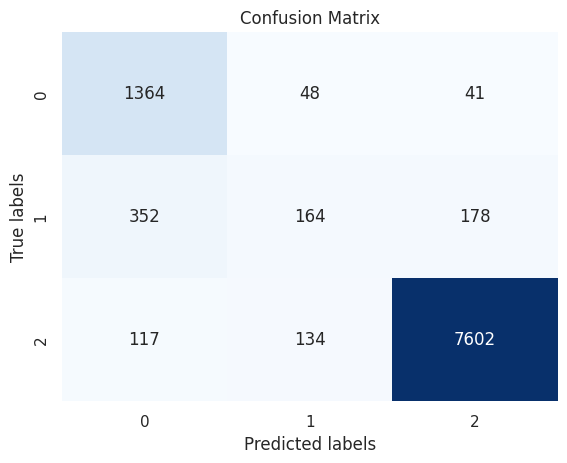

Accuracy: 0.913
Accuracy for label 0: 0.939
Accuracy for label 1: 0.236
Accuracy for label 2: 0.968
Classification Report:
{'0': {'precision': 0.7441352973267867, 'recall': 0.9387474191328287, 'f1-score': 0.8301886792452831, 'support': 1453}, '1': {'precision': 0.47398843930635837, 'recall': 0.23631123919308358, 'f1-score': 0.3153846153846154, 'support': 694}, '2': {'precision': 0.9719984656693518, 'recall': 0.9680376926015536, 'f1-score': 0.9700140359831568, 'support': 7853}, 'accuracy': 0.913, 'macro avg': {'precision': 0.7300407341008323, 'recall': 0.7143654503091552, 'f1-score': 0.7051957768710184, 'support': 10000}, 'weighted avg': {'precision': 0.9043280514795854, 'recall': 0.913, 'f1-score': 0.9042661298596051, 'support': 10000}}


{'accuracy': 0.913,
 'precision_weighted': 0.9043280514795854,
 'recall_weighted': 0.913,
 'f1_weighted': 0.9042661298596051,
 'precision_macro': 0.7300407341008323,
 'recall_macro': 0.7143654503091552,
 'f1_macro': 0.7051957768710184}

In [ ]:
compute_metrics(y_true, trained_model_y_pred_filled)

### Model without Fine-Tuning

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
model_original, tokenizer_original = create_model_and_tokenizer(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Evaluation of 10.000 test data took about 55 minutes
original_model_y_pred = [predict_sentiment(model_original, tokenizer_original, prompt) for prompt in dataset_dict['test']['prompt']]
print([item for item in original_model_y_pred if item not in ['0', '1', '2']])
original_model_y_pred_filled = [1 if item not in ['0', '1', '2'] else int(item) for item in original_model_y_pred]
print([item for item in original_model_y_pred_filled if item not in [0, 1, 2]])

['##', '', '', '', '', '', '', '', '', '', '****', '<', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'The', 'The', '', '', '', '', '', '', '', '', '', '##', '', '****', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '****', '', '', '', '', '', '', '', '<', '', '', '', '', '##', '', 'The', '', '', '', '', '', '', '', '', '', '##', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'The', '', '', '', '', '', '', '', '', '<', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ':', '', '', '', '', '', '', '', '', '', '****', '', '', '', '', '', '', '<', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '<', '', '', '', '', '', '', '', '', '', '', 'The', '', '', '', '', '', '', '', '', '', ''

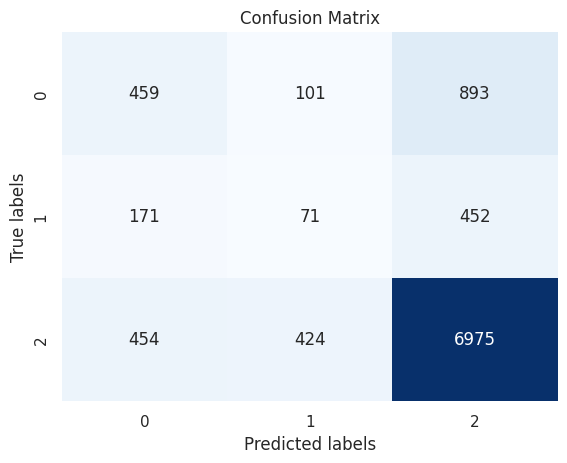

Accuracy: 0.7505
Accuracy for label 0: 0.316
Accuracy for label 1: 0.102
Accuracy for label 2: 0.888
Classification Report:
{'0': {'precision': 0.42343173431734316, 'recall': 0.31589814177563663, 'f1-score': 0.3618446984627513, 'support': 1453}, '1': {'precision': 0.11912751677852348, 'recall': 0.10230547550432277, 'f1-score': 0.11007751937984497, 'support': 694}, '2': {'precision': 0.8383413461538461, 'recall': 0.8881955940404941, 'f1-score': 0.8625486922648858, 'support': 7853}, 'accuracy': 0.7505, 'macro avg': {'precision': 0.4603001990832376, 'recall': 0.4354664037734845, 'f1-score': 0.44482363670249403, 'support': 10000}, 'weighted avg': {'precision': 0.7281415397953549, 'recall': 0.7505, 'f1-score': 0.7375749025672138, 'support': 10000}}


{'accuracy': 0.7505,
 'precision_weighted': 0.7281415397953549,
 'recall_weighted': 0.7505,
 'f1_weighted': 0.7375749025672138,
 'precision_macro': 0.4603001990832376,
 'recall_macro': 0.4354664037734845,
 'f1_macro': 0.44482363670249403}

In [ ]:
compute_metrics(y_true, original_model_y_pred_filled)

## Evaluate Generalization

### Load Data

In [ ]:
from sklearn.model_selection import train_test_split

base_data_path = './data_for_export'

print(80*'=')
generalization_data = pd.read_csv(f'{base_data_path}/combined_generalization_data.csv')
generalization_data = generalization_data.reset_index(drop=True)
print('Generalization Data:')
print(generalization_data.shape)
print(generalization_data.head(3))

Generalization Data:
(30000, 3)
                                                Text  Sentiment  Origin
0  I know that there are divided camps when it co...          0  Amazon
1  The owner responded to my Yelp comment and off...          1    Yelp
2  At first I didn't like the Idea of eating a su...          2    Yelp


In [ ]:
generalization_data['prompt'] = generalization_data.apply(generate_test_prompt, axis=1)

In [ ]:
print(generalization_data['prompt'][0])

### Instruction: Below is the text of a customer review. Analyze the sentiment of the customer review and determine if it is positive (2), neutral (1), or negative (0), and return the answer as the corresponding sentiment label 2 or 1 or 0.

### Input:
I know that there are divided camps when it comes to whether or not shipping issues should be part of a product review.  I generally think that shipping is a separate concern, but I'm not so sure after this purchase!  I purchased this product from D.M.E. ONLINE SALES INC (AKA Medical Supply Superstore), but it was shipped by Amazon.  When the package arrived, more than a quarter of it had leaked through both the padded manilla envelope and the box it was shipped in, staining the other item in the box (gloves), as well as the outside of the box that was delivered.  I contacted D.M.E. and they said that it was not their responsability because they didn't handle the shipping.  Which I would agree with, except that there was NOTHING wrong wi

In [ ]:
# Umwandeln der Pandas DataFrames in Hugging Face Datasets
generalization_dataset = Dataset.from_pandas(generalization_data[['prompt', 'Sentiment']])
generalization_dataset

Dataset({
    features: ['prompt', 'Sentiment'],
    num_rows: 30000
})

In [ ]:
y_true = generalization_dataset['Sentiment']

### Fine-Tuned Model

In [ ]:
# Evaluation of 30.000 test data took about 3 hours, 9 minutes
geneneral_trained_model_y_pred = [predict_sentiment(trained_model, trained_tokenizer, prompt) for prompt in generalization_dataset['prompt']]
print([item for item in geneneral_trained_model_y_pred if item not in ['0', '1', '2']])
geneneral_trained_model_y_pred_filled = [1 if item not in ['0', '1', '2'] else int(item) for item in geneneral_trained_model_y_pred]
print([item for item in geneneral_trained_model_y_pred_filled if item not in [0, 1, 2]])

['', '', '4', '', '', '', '', '', '', '', '4', '', '', '', 'I', '', '', '5', '', '', '', '', '5', '', '', '', '', '', '', '', '', '4', '', '', '', '', '', '', '', '', '', '']
[]


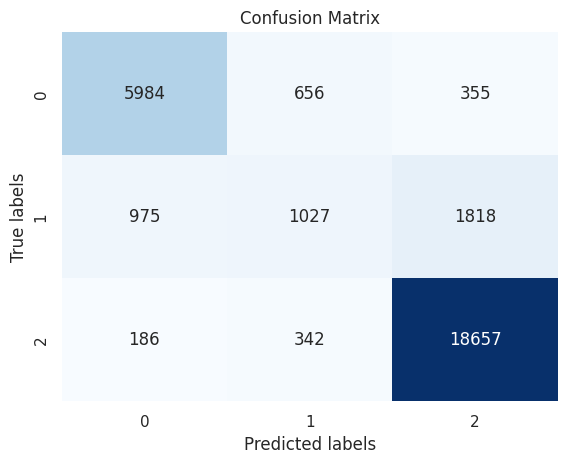

Accuracy: 0.8556
Accuracy for label 0: 0.855
Accuracy for label 1: 0.269
Accuracy for label 2: 0.972
Classification Report:
{'0': {'precision': 0.8375087473757873, 'recall': 0.8554681915654039, 'f1-score': 0.8463932107496464, 'support': 6995}, '1': {'precision': 0.5071604938271604, 'recall': 0.268848167539267, 'f1-score': 0.3514114627887083, 'support': 3820}, '2': {'precision': 0.8956793086893903, 'recall': 0.9724784988272087, 'f1-score': 0.9325003123828565, 'support': 19185}, 'accuracy': 0.8556, 'macro avg': {'precision': 0.7467828499641126, 'recall': 0.6989316193106264, 'f1-score': 0.710101661973737, 'support': 30000}, 'weighted avg': {'precision': 0.8326444770506446, 'recall': 0.8556, 'f1-score': 0.8384310263370581, 'support': 30000}}


{'accuracy': 0.8556,
 'precision_weighted': 0.8326444770506446,
 'recall_weighted': 0.8556,
 'f1_weighted': 0.8384310263370581,
 'precision_macro': 0.7467828499641126,
 'recall_macro': 0.6989316193106264,
 'f1_macro': 0.710101661973737}

In [ ]:
compute_metrics(y_true, geneneral_trained_model_y_pred_filled)

### Model without Fine-Tuning

In [ ]:
# Evaluation of 30.000 test data took about 3h X minutes
geneneral_original_model_y_pred = [predict_sentiment(model_original, tokenizer_original, prompt) for prompt in generalization_dataset['prompt']]
print([item for item in geneneral_original_model_y_pred if item not in ['0', '1', '2']])
geneneral_original_model_y_pred_filled = [1 if item not in ['0', '1', '2'] else int(item) for item in geneneral_original_model_y_pred]
print([item for item in geneneral_original_model_y_pred_filled if item not in [0, 1, 2]])

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '##', '', '', '', '', '', '', '', '', '', '##', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'The', '****', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '##', '', '', '', '', 'S', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '****', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '##', '', '', '', '', '##', '', '', '', '', '', '', '', '', '', '##', '', '', '', '', '', '', '', '', '', '', '', '', '', '##', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '##', '', '', '', '', '',

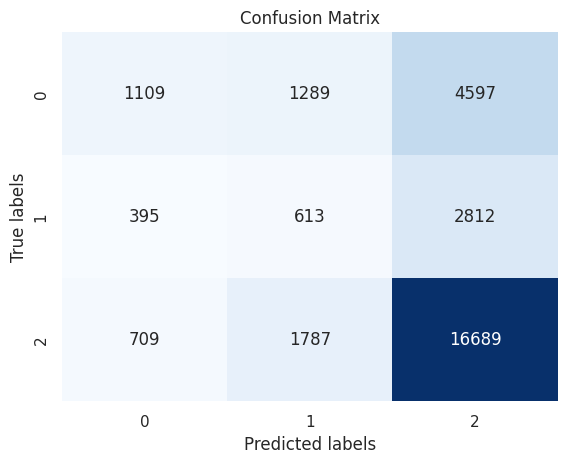

Accuracy: 0.6137
Accuracy for label 0: 0.159
Accuracy for label 1: 0.160
Accuracy for label 2: 0.870
Classification Report:
{'0': {'precision': 0.5011296882060551, 'recall': 0.15854181558255898, 'f1-score': 0.24087749782797566, 'support': 6995}, '1': {'precision': 0.16616969368392517, 'recall': 0.16047120418848168, 'f1-score': 0.16327074177653483, 'support': 3820}, '2': {'precision': 0.6925470993443439, 'recall': 0.8698983580922596, 'f1-score': 0.7711572672873875, 'support': 19185}, 'accuracy': 0.6137, 'macro avg': {'precision': 0.45328216041144137, 'recall': 0.3963037926211001, 'f1-score': 0.39176850229729937, 'support': 30000}, 'weighted avg': {'precision': 0.5808895499931729, 'recall': 0.6137, 'f1-score': 0.5701094834600527, 'support': 30000}}


{'accuracy': 0.6137,
 'precision_weighted': 0.5808895499931729,
 'recall_weighted': 0.6137,
 'f1_weighted': 0.5701094834600527,
 'precision_macro': 0.45328216041144137,
 'recall_macro': 0.3963037926211001,
 'f1_macro': 0.39176850229729937}

In [ ]:
compute_metrics(y_true, geneneral_original_model_y_pred_filled)